## Deep Learning Neural Network on Digits Recognition Using Keras

## Introduction

This project is to build a Sequential Convolutional Neural Network model for digits recognition trained on MNIST dataset using Keras API.

This notebook is adapted from Yassine Ghouzam on Kaggle.
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

## Project Goal

To correctly identify digits from a dataset of tens of thousands of handwritten images.


## Dataset

Source of the dataset: https://www.kaggle.com/c/digit-recognizer/data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

## Data Preprocessing

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [17]:
# Import the data
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

### Data Exploration

In [18]:
train.shape

(42000, 785)

In [3]:
test.shape

(28000, 784)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

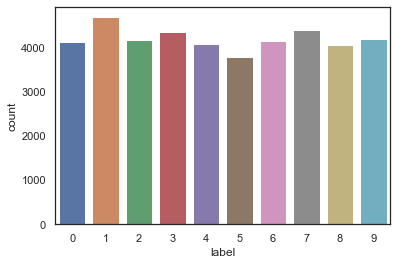

In [19]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# delete train to free up some space
del train 

graph = sns.countplot(Y_train)

Y_train.value_counts()

In [7]:
# Check for missing value on train dataset
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
# Check for missing value on test dataset
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing value

### Normalization


We perform a grayscale normalization as the CNN converg faster on 0 to 1 data than on 0 to 255.

In [21]:
# Normalize the pixel (features) data
X_train = X_train / 255.0
test = test / 255.0

### Reshape Data

Train and test images (28px x 28px) has been imported as 1D vectors of 784 values. We convert all data to 28x28x1 3D matrices.

Keras requires an extra dimension which corresponds to channels. MNIST images are gray scaled so it only has one channel.

In [22]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , depth = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### One hot encoding of labels

We transform target label for the training samples into an array of 1s and 0s where the index of the number 1 indicates the digit of the image represents. (e.g. 3 -> [0,0,0,1,0,0,0,0,0,0])

In [23]:
# Encode labels (response variable) to one-hot vectors
Y_train = to_categorical(Y_train, num_classes = 10)

/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


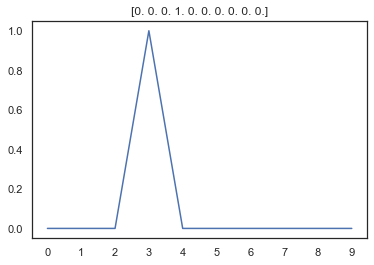

In [91]:
plt.title(Y_train[9])
plt.plot(Y_train[9])
plt.xticks(range(10));

### Build Training and Validation Samples

In [24]:
# Set the random seed
random_seed = 2

In [25]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1,
                                                  random_state=random_seed)

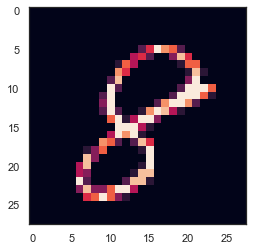

In [28]:
plt.imshow(X_train[0][:,:,0]);

## CNNs (Convolutional Neural Networks)

The first layer is the convolutional (Conv2D) layer which acts as filters. Each filter transforms a part of the image using the kernel filter. The kernel filter matrix is applied on the whole image.

The second layer in CNN is the pooling (MaxPool2D) layer. This layer acts as a downsampling filter by looking at the 2 neighboring pixels and picks the maximum value. It can be used to reduce computational cost and overfitting.

Dropout is a regularization technique used to prevent a model from overfitting. Dropout is implemented by randomly selecting nodes to be dropped-out (setting their weights to zero) with a given probability at each update of the training phase.

The Flatten layer is use to convert the final feature maps into a single 1D array. 

'relu' (rectifier linear unit) is the rectifier with activation function max(0,x). The rectifier activation function is used to add non-linearity to the network.

The softmax activation function will return the probability that a sample represents a given digit.

In [92]:
# Build the CNN model 
# CNN architechture: 
# [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output

# Instantiate a sequential model
model = Sequential()

# Add a convolutional layer with 32 filters of size 5x5
# (It will learn 32 different convolutional masks for 28x28 B&W images)
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))

# Add another convolutional layer
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

# Add a pooling layer and droput
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Add a convolutional layer with 64 filters of size 3x3
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

# Add another convolutional layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

# Add a pooling layer and dropuot
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Flatten the output of the previous layer
model.add(Flatten())

# Add a hidden dense layer of 256 neurons and dropout
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))

# End this multi-class model with 10 outputs and softmax
model.add(Dense(10, activation = "softmax"))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

### Set the optimizer and compile the model

We compile the model by specifying an optimizer, a loss function, and a score function. 

The optimizer function will iteratively improve parameters (e.g. filters kernel values, weights and bias of neurons) in order to minimise the loss.

RMSprop is used with default values because it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in order to reduce its aggressive, monotonically decreasing learning rate. Stochastic Gradient Descent ('sgd') optimizer can be used instead but it is slower than RMSprop.

The loss function measures model's performance on images with known labels. It is the error rate between the observed labels and the predicted outcome. "categorical_crossentropy" is the categorical classification for multiple classes (2 or more).

The metric function "accuracy" is used to evaluate the performance of the model.

In [30]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [31]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Set the learning rate annealer

In order to make the optimizer converge faster and closer to the global minimum of the loss function, an annealing method of the learning rate (LR) is used.

The learning rate is a hyperparameter that determine how much to change the model (e.g. it informs the optimizer how far to move the weights) in response to the estimated error each time the model weights are updated.

If the learning rate is low, training will be more reliable, but optimization will be time-consuming because it takes many tiny steps to reach the global minimum.
If the learning rate is high, then training may not converge or even diverge because weight changes can be so big that the optimizer misses the minimum.

Its better to have a decreasing learning rate during the training to reach the global minimum of the loss function efficiently

By using the ReduceLROnPlateau function from Keras.callbacks, LR will be reduced by half if the accuracy is not improved after 3 epochs.

In [32]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [47]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### Data augmentation

Data augmentation is a strategy that significantly increase the diversity of data available for training models by using small transformations such as cropping, padding, rotationand horizontal flipping. It can be used to prevent overfitting problem. 

By applying some of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [34]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [48]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Epoch 1/30
 - 90s - loss: 0.1351 - acc: 0.9601 - val_loss: 0.0499 - val_acc: 0.9871
Epoch 2/30
 - 89s - loss: 0.0988 - acc: 0.9717 - val_loss: 0.0366 - val_acc: 0.9874
Epoch 3/30
 - 143s - loss: 0.0823 - acc: 0.9753 - val_loss: 0.0304 - val_acc: 0.9900
Epoch 4/30
 - 96s - loss: 0.0746 - acc: 0.9783 - val_loss: 0.0278 - val_acc: 0.9921
Epoch 5/30
 - 94s - loss: 0.0677 - acc: 0.9802 - val_loss: 0.0289 - val_acc: 0.9912
Epoch 6/30
 - 95s - loss: 0.0652 - acc: 0.9811 - val_loss: 0.0402 - val_acc: 0.9907
Epoch 7/30
 - 92s - loss: 0.0644 - acc: 0.9820 - val_loss: 0.0258 - val_acc: 0.9926
Epoch 8/30
 - 92s - loss: 0.0604 - acc: 0.9833 - val_loss: 0.0419 - val_acc: 0.9898
Epoch 9/30
 - 92s - loss: 0.0604 - acc: 0.9829 - val_loss: 0.0208 - val_acc: 0.9926
Epoch 10/30
 - 92s - loss: 0.0608 - acc: 0.9827 - val_loss: 0.0296 - val_acc: 0.9938
Epoch 11/30
 - 92s - loss: 0.0629 - acc: 0.9829 - val_loss: 0.0192 - val_acc: 0.9933
Epoch 12/30
 - 92s - loss: 0.0627 - acc: 0.9832 - val_loss: 0.0276 - val_

## Evaluate the model

### Training and validation curves

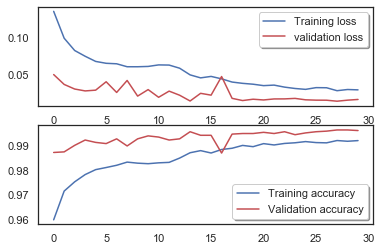

In [49]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The model has 99% accuracy on the training set and 99.6% on the validation set.

## Confusion Matrix

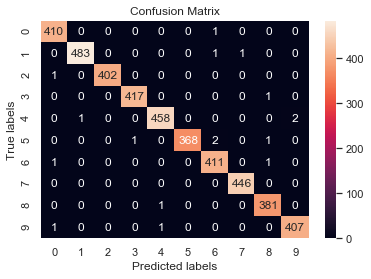

In [78]:
# Plot confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True, fmt='d')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix'); 

The CNN model performs very well on all digits with few errors.

### Plots on prediction errors 

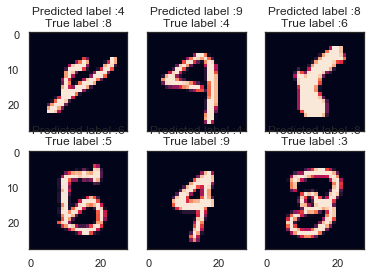

In [69]:
# Create plots on prediction errors 

# Errors are differences between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [79]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")